## Data Splitting Notebook

We have three available datasets:
1. 20 images annotated together by our 2 annotators
2. 20 images with duplicated annotations
3. 60 images with single annotations produced by one of our annotators (50% each)

We aim to split the aforementioned data as follows:

- **Tets split:** 5 images from 1. and 10 images fomr 3 (5 for each annotator).
- **Validation split:** same as above.
- **Train split:** 10 images form 1., all images fomr 2. with randomly sampled annotations, 40 images form 3.

In [9]:
import os
import sys
import shutil
sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from src.model.dataset import MaskRCNNDataset
from src.utils.utils import *
from src.utils.const import *


In [10]:
# annotated dataset
dataset_1 = "../dataset/merge_together_corrected_m"
dataset_2_LT = "../dataset/merge_alone_1_corrected_LT_m"
dataset_2_EK = "../dataset/merge_alone_1_corrected_EK_m"
dataset_3 = "../dataset/merge_alone_2_corrected_LT_m"
dataset_4 = "../dataset/merge_alone_3_corrected_EK_m"

images_paths_train = []
images_paths_val = []
images_paths_test = []

random_seed = 1234
np.random.seed(random_seed)

In [ ]:
def create_dataset(images_paths, dataset_path):
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path)
    os.makedirs(os.path.join(dataset_path, IMAGES_SUBFOLDER), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, ANNOTATIONS_SUBFOLDER), exist_ok=True)
    for image_path in images_paths:
        # get the target path for the image
        old_dataset_path = os.path.join(*image_path.split(os.sep)[:-4])
        target_path = get_annotations_paths([image_path], old_dataset_path)[0]
        # copy the image and the annotation to the dataset folder
        image_rel_path = os.path.join(*image_path.split(os.sep)[-3:])
        target_rel_path = os.path.join(*target_path.split(os.sep)[-3:])
        os.makedirs(os.path.join(dataset_path, IMAGES_SUBFOLDER, os.path.dirname(image_rel_path)), exist_ok=True)
        os.makedirs(os.path.join(dataset_path, ANNOTATIONS_SUBFOLDER, os.path.dirname(target_rel_path)), exist_ok=True)
        shutil.copyfile(image_path, os.path.join(dataset_path, IMAGES_SUBFOLDER ,image_rel_path))
        shutil.copyfile(target_path, os.path.join(dataset_path, ANNOTATIONS_SUBFOLDER, target_rel_path))

## Dataset 1

We split it into three subsets of size 25%, 25% and 50%.

Number of images in dataset 1: 20


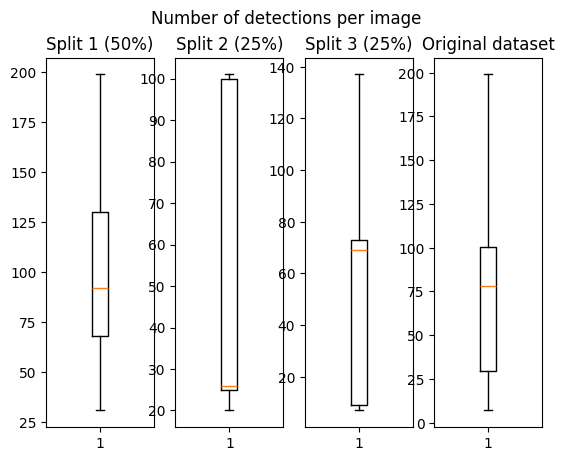

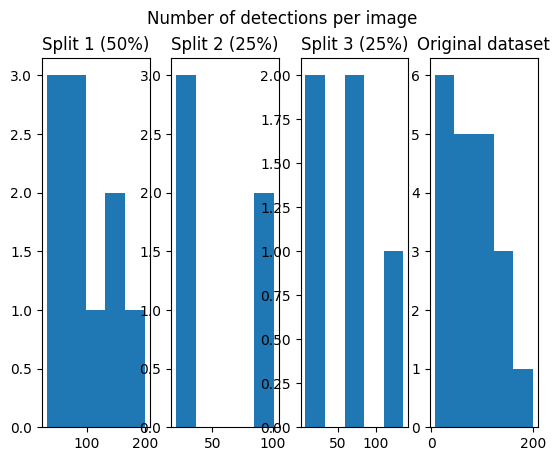

In [12]:
image_paths_1 = get_images_paths(dataset_1)
print(f"Number of images in dataset 1: {len(image_paths_1)}")
target_paths_1 = get_annotations_paths(image_paths_1, dataset_1)
nr_detections_1 = []
for target_path in target_paths_1:
    target = pd.read_csv(target_path)
    nr_detections_1.append(len(target))


x_1, x_temp, y_1, y_temp = train_test_split(image_paths_1, nr_detections_1, test_size=0.5)
x_2, x_3, y_2, y_3 = train_test_split(x_temp, y_temp, test_size=0.5)



images_paths_train.extend(x_1)
images_paths_val.extend(x_2)
images_paths_test.extend(x_3)

figure, ax = plt.subplots(1, 4)
ax[0].boxplot(y_1)
ax[0].set_title("Split 1 (50%)")
ax[1].boxplot(y_2)
ax[1].set_title("Split 2 (25%)")
ax[2].boxplot(y_3)
ax[2].set_title("Split 3 (25%)")
ax[3].boxplot(nr_detections_1)
ax[3].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()

figure, ax = plt.subplots(1, 4)
ax[0].hist(y_1, bins=5)
ax[0].set_title("Split 1 (50%)")
ax[1].hist(y_2, bins=5)
ax[1].set_title("Split 2 (25%)")
ax[2].hist(y_3, bins=5)
ax[2].set_title("Split 3 (25%)")
ax[3].hist(nr_detections_1, bins=5)
ax[3].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()



## Dataset 2

Here we first need to merge the two annotations into a sigle one, by adding an additional columnrepresentig the annotator corresponding to the detection

In [13]:
# merge the two datasets
image_paths_1 = get_images_paths(dataset_2_LT)
target_paths_1 = get_annotations_paths(image_paths_1, dataset_2_LT)
image_paths_2 = get_images_paths(dataset_2_EK)
target_paths_2 = get_annotations_paths(image_paths_2, dataset_2_EK)
images_paths_new = []

new_dataset = "../dataset/merge_alone_1_corrected_m"
os.makedirs(os.path.join(new_dataset, IMAGES_SUBFOLDER), exist_ok=True)
os.makedirs(os.path.join(new_dataset, ANNOTATIONS_SUBFOLDER), exist_ok=True)

for image_path_1, image_path_2, target_path_1, target_path_2 in zip(image_paths_1, image_paths_2 ,target_paths_1, target_paths_2):
    image_rel_path = os.path.join(*image_path_1.split(os.sep)[-3:])
    image_rel_path_2 = os.path.join(*image_path_2.split(os.sep)[-3:])
    assert image_rel_path == image_rel_path_2, "The images do not correspond"
    target_rel_path = os.path.join(*target_path_1.split(os.sep)[-3:])
    df_1 = pd.read_csv(target_path_1)
    df_1["annotator"] = 1
    df_2 = pd.read_csv(target_path_2)
    df_2["annotator"] = 2
    df = pd.concat([df_1, df_2])

    os.makedirs(os.path.join(new_dataset, IMAGES_SUBFOLDER, os.path.dirname(image_rel_path)), exist_ok=True)
    os.makedirs(os.path.join(new_dataset, ANNOTATIONS_SUBFOLDER, os.path.dirname(target_rel_path)), exist_ok=True)
    image_path_new = os.path.join(new_dataset, IMAGES_SUBFOLDER, image_rel_path)
    shutil.copyfile(image_path_1, image_path_new)
    df.to_csv(os.path.join(new_dataset, ANNOTATIONS_SUBFOLDER, target_rel_path), index=False)
    images_paths_new.append(image_path_new)

images_paths_train.extend(images_paths_new)

## Dataset 3

We deal with this dataset similarly to dataset 1, but in our case we split in 5,5,20 images for each annotator

20 5 5


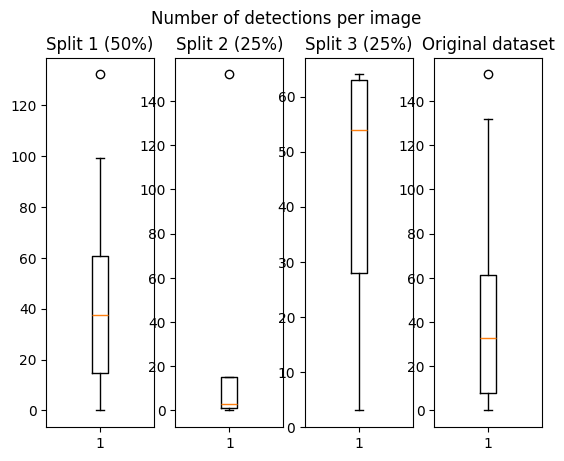

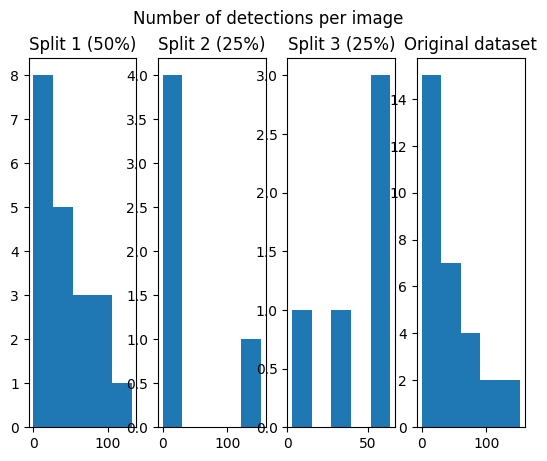

In [14]:
image_paths_3 = get_images_paths(dataset_3)
target_paths_3 = get_annotations_paths(image_paths_3, dataset_3)
nr_detections_3 = []
for target_path in target_paths_3:
    target = pd.read_csv(target_path)
    nr_detections_3.append(len(target))

x_1, x_temp, y_1, y_temp = train_test_split(image_paths_3, nr_detections_3, train_size=20)
x_2, x_3, y_2, y_3 = train_test_split(x_temp, y_temp, test_size=0.5)

print(len(x_1), len(x_2), len(x_3))
images_paths_train.extend(x_1)
images_paths_val.extend(x_2)
images_paths_test.extend(x_3)

figure, ax = plt.subplots(1, 4)
ax[0].boxplot(y_1)
ax[0].set_title("Split 1 (50%)")
ax[1].boxplot(y_2)
ax[1].set_title("Split 2 (25%)")
ax[2].boxplot(y_3)
ax[2].set_title("Split 3 (25%)")
ax[3].boxplot(nr_detections_3)
ax[3].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()

figure, ax = plt.subplots(1, 4)
ax[0].hist(y_1, bins=5)
ax[0].set_title("Split 1 (50%)")
ax[1].hist(y_2, bins=5)
ax[1].set_title("Split 2 (25%)")
ax[2].hist(y_3, bins=5)
ax[2].set_title("Split 3 (25%)")
ax[3].hist(nr_detections_3, bins=5)
ax[3].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()






20 5 5


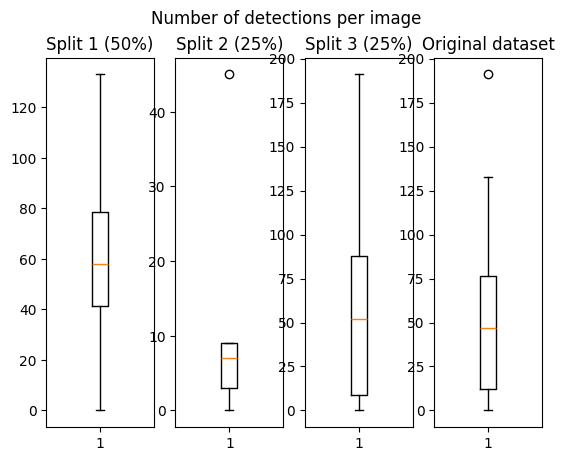

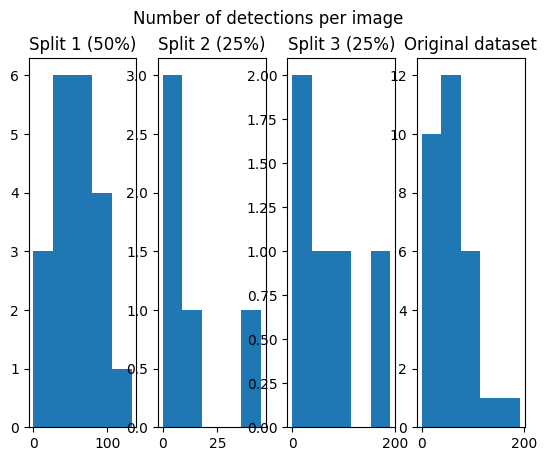

In [15]:
image_paths_4 = get_images_paths(dataset_4)
target_paths_4 = get_annotations_paths(image_paths_4, dataset_4)
nr_detections_4 = []
for target_path in target_paths_4:
    target = pd.read_csv(target_path)
    nr_detections_4.append(len(target))

x_1, x_temp, y_1, y_temp = train_test_split(image_paths_4, nr_detections_4, train_size=20)
x_2, x_3, y_2, y_3 = train_test_split(x_temp, y_temp, test_size=0.5)

print(len(x_1), len(x_2), len(x_3))
images_paths_train.extend(x_1)
images_paths_val.extend(x_2)
images_paths_test.extend(x_3)

figure, ax = plt.subplots(1, 4)
ax[0].boxplot(y_1)
ax[0].set_title("Split 1 (50%)")
ax[1].boxplot(y_2)
ax[1].set_title("Split 2 (25%)")
ax[2].boxplot(y_3)
ax[2].set_title("Split 3 (25%)")
ax[3].boxplot(nr_detections_4)
ax[3].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()

figure, ax = plt.subplots(1, 4)
ax[0].hist(y_1, bins=5)
ax[0].set_title("Split 1 (50%)")
ax[1].hist(y_2, bins=5)
ax[1].set_title("Split 2 (25%)")
ax[2].hist(y_3, bins=5)
ax[2].set_title("Split 3 (25%)")
ax[3].hist(nr_detections_4, bins=5)
ax[3].set_title("Original dataset")
figure.suptitle("Number of detections per image")
plt.show()


## Creta Train, Val e Test datasets

In [16]:
train_dataset = "../dataset/train"
val_dataset = "../dataset/val"
test_dataset = "../dataset/test"

create_dataset(images_paths_train, train_dataset)
create_dataset(images_paths_val, val_dataset)
create_dataset(images_paths_test, test_dataset)